<a href="https://colab.research.google.com/github/ParthDave111/financial-engineering-/blob/main/Stock_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -Uqq arch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.4/983.4 kB 6.9 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, coint
from statsmodels.stats.stattools import durbin_watson
from statsmodels.tsa.ardl import UECM
from arch.unitroot import ADF
from arch.unitroot.cointegration import phillips_ouliaris


## Step 1

Synthetic data is used to implement ECM, calibrate and interpret the paramters

In [3]:
# Generate synthetic data
np.random.seed(42)
n = 100
time = np.arange(n)
income = np.cumsum(np.random.normal(size=n))
consumption = 0.5 * income + np.random.normal(size=n)

# Convert to pandas DataFrame
data = pd.DataFrame({'income': income, 'consumption': consumption})

# Test for stationarity
adf_income = adfuller(data['income'])
adf_consumption = adfuller(data['consumption'])
print(f'ADF Test for Income: {adf_income[1]}')
print(f'ADF Test for Consumption: {adf_consumption[1]}')

# Test for cointegration
coint_test = coint(data['consumption'], data['income'])
print(f'Cointegration Test p-value: {coint_test[1]}')

# Estimate long-run relationship
long_run_model = sm.OLS(data['consumption'], sm.add_constant(data['income'])).fit()
data['residuals'] = long_run_model.resid

# Create lagged variables
data['diff_consumption'] = data['consumption'].diff()
data['diff_income'] = data['income'].diff()
data['lagged_residuals'] = data['residuals'].shift(1)

# Drop missing values
data = data.dropna()

# Test for stationarity for first differences
adf_diff_income = adfuller(data['diff_income'])
adf_diff_consumption = adfuller(data['diff_consumption'])
print(f'ADF Test for First Difference Income: {adf_diff_income[1]}')
print(f'ADF Test for First Difference Consumption: {adf_diff_consumption[1]}')

# Estimate ECM
ecm_model = sm.OLS(data['diff_consumption'], sm.add_constant(data[['diff_income', 'lagged_residuals']])).fit()
print(ecm_model.summary())

ADF Test for Income: 0.6020814791099098
ADF Test for Consumption: 0.2882859880761256
Cointegration Test p-value: 1.2605631706311226e-18
ADF Test for First Difference Income: 1.800687720719554e-17
ADF Test for First Difference Consumption: 8.165495307001971e-10
                            OLS Regression Results                            
Dep. Variable:       diff_consumption   R-squared:                       0.602
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     72.49
Date:                Tue, 02 Jul 2024   Prob (F-statistic):           6.52e-20
Time:                        20:03:51   Log-Likelihood:                -133.17
No. Observations:                  99   AIC:                             272.3
Df Residuals:                      96   BIC:                             280.1
Df Model:                           2                                         
Covariance Type:            

## Step 2

Pepsi (PEP) and Coca-cola (KO) stocks daily data for 10 years are first downloaded using yFinance API. Then they are tested for stationarity and cointegration.

In [4]:
# Download daily data for PepsiCo (PEP) and Coca-Cola (KO) for the last 10 years
start_date = '2014-01-01'
end_date = '2024-01-01'
pep = yf.download('PEP', start=start_date, end=end_date)['Adj Close']
ko = yf.download('KO', start=start_date, end=end_date)['Adj Close']


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [5]:
def adf_test(series, label=''):
    result = adfuller(series.dropna())
    print(label)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

In [6]:
for v, label in zip([pep, ko, pep.diff().dropna(), ko.diff().dropna()], ['PEP', 'KO', 'PEP First Difference', 'KO First Difference']):
    adf_test(v, label)
    print('===========')

PEP
ADF Statistic: -0.7504116662845428
p-value: 0.8332562708713712
KO
ADF Statistic: -0.9578149540781579
p-value: 0.7683378473168025
PEP First Difference
ADF Statistic: -15.251913097463255
p-value: 4.995764591957569e-28
KO First Difference
ADF Statistic: -14.693937493425418
p-value: 3.019042239605056e-27


From the test result above, PEP and KO cannot reject ADF null hyptothesis that it contains unit root, whereas the first differences for both rejected the null hypthesis. Hence PEP and KO are I(1)

In [7]:
# cointegration test using statsmodel library
coint(pep, ko)

(-4.189461020769318,
 0.003784256641354602,
 array([-3.90079993, -3.33856054, -3.04613679]))

In [8]:
# cointegration test using PO test
print(phillips_ouliaris(pep, ko, trend="c", test_type="Za", kernel="bartlett"))

Phillips-Ouliaris Za Cointegration Test
Statistic: -37.87095174359033
P-value: 0.001321464005745906
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 2.6557
Trend: c
Distribution Order: 3


From the PO test, p-value < 0.05 rejects the null hypothesis and shows that these PEP and KO are cointegrated

## Step 3

An ECM model is fitted over PEP and KO. The parameters fitted are then interpreted.

### Diagram and Diagnosis

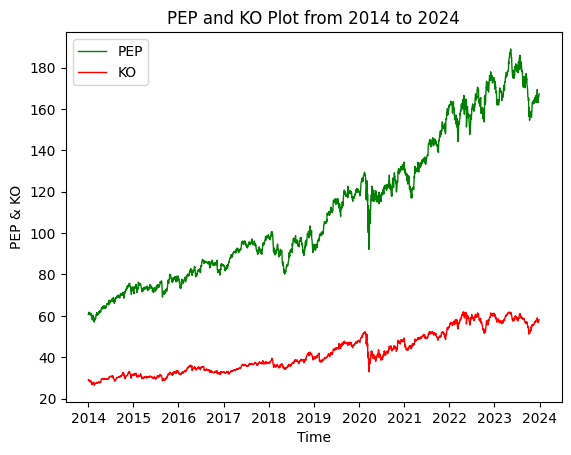

In [9]:
# PEP and KO Plot from 2014 to 2024
plt.plot(pep, linewidth=1, c="g", label="PEP")
plt.plot(ko, linewidth=1, c="r", label="KO")
plt.xlabel("Time")
plt.ylabel("PEP & KO")
plt.title('PEP and KO Plot from 2014 to 2024')
plt.legend()
plt.show()


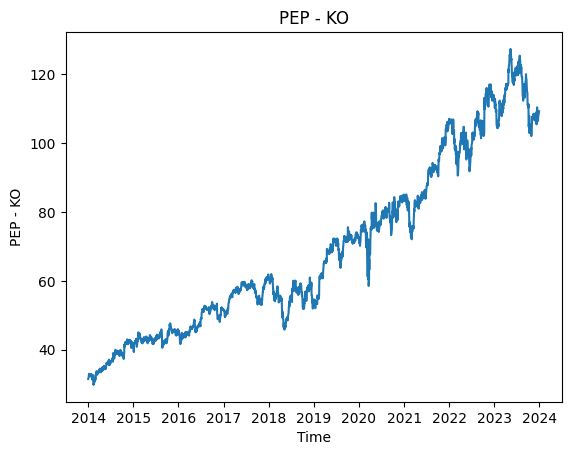

In [10]:
# Differences between PEP and KO from 2014 to 2024
plt.plot(pep - ko)
plt.xlabel("Time")
plt.ylabel("PEP - KO")
plt.title('PEP - KO')
plt.show()

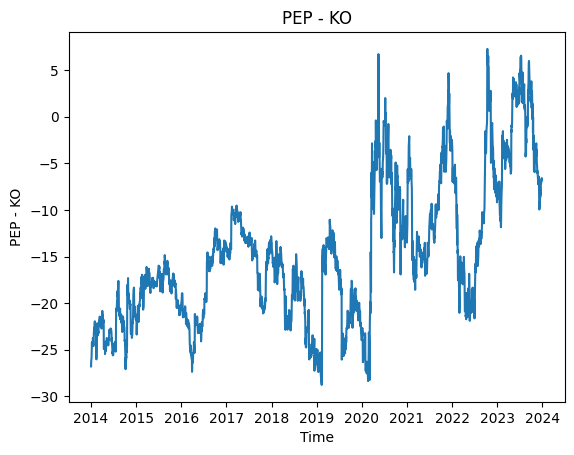

In [11]:
# Differences between PEP and KO from 2014 to 2024
plt.plot(pep - 3*ko)
plt.xlabel("Time")
plt.ylabel("PEP - KO")
plt.title('PEP - KO')
plt.show()

From Figure above, it can be seen that the residual moves in a broad channel

In [13]:
# ADF test for PEP and KO
pep_adf = ADF(pep, trend="n", method="bic")
print('PEP test statistics with critical values')
print(pep_adf)
print("PEP\n", pep_adf.regression.summary())

print('\n\n')
ko_adf = ADF(ko, trend="n", method="bic")
print('KO test statistics with critical values')
print(ko_adf)
print("KO\n", ko_adf.regression.summary())

PEP test statistics with critical values
   Augmented Dickey-Fuller Results   
Test Statistic                  1.377
P-value                         0.957
Lags                                9
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
PEP
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.050
Model:                            OLS   Adj. R-squared (uncentered):              0.046
Method:                 Least Squares   F-statistic:                              13.04
Date:                Tue, 02 Jul 2024   Prob (F-statistic):                    1.65e-22
Time:                        20:04:28   Log-Likelihood:                         -4252.7
No. Observations:                2506   AIC:             

In [14]:
# ADF test for first differences of PEP and KO
pep_diff_adf = ADF(pep.diff().dropna(), trend="n", method="bic")
print('First difference PEP test statistics with critical values')
print(pep_diff_adf)
print("PEP\n", pep_diff_adf.regression.summary())

print('\n\n')
ko_diff_adf = ADF(ko.diff().dropna(), trend="n", method="bic")
print('First difference KO test statistics with critical values')
print(ko_diff_adf)
print("KO\n", ko_diff_adf.regression.summary())

First difference PEP test statistics with critical values
   Augmented Dickey-Fuller Results   
Test Statistic                -15.153
P-value                         0.000
Lags                                8
-------------------------------------

Trend: No Trend
Critical Values: -2.57 (1%), -1.94 (5%), -1.62 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.
PEP
                                  OLS Regression Results                                
Dep. Variable:                      y   R-squared (uncentered):                   0.587
Model:                            OLS   Adj. R-squared (uncentered):              0.585
Method:                 Least Squares   F-statistic:                              393.7
Date:                Tue, 02 Jul 2024   Prob (F-statistic):                        0.00
Time:                        20:04:33   Log-Likelihood:                         -4253.7
No. Observations:                2506   

From the ADF test, we can conclude that PEP and KO are I(1)

In [15]:
# Summary table for ADF tests
pd.DataFrame({'PEP': [pep_adf.stat, pep_adf.pvalue], 'KO': [ko_adf.stat, ko_adf.pvalue],
              'PEP_diff': [pep_diff_adf.stat, pep_diff_adf.pvalue], 'KO_diff': [ko_diff_adf.stat, ko_diff_adf.pvalue]}, index=['Test Statistics', 'P-value'])

,PEP,KO,PEP_diff,KO_diff
Test Statistics,1.376876,0.888777,-1.515323e+01,-22.333821
P-value,0.957419,0.899576,7.785806e-27,0.000000


KPSS Test

In [18]:
!pip install statsmodels
import statsmodels.tsa.stattools as ts

In [19]:
def kpss_test(series, title=''):
    result = ts.kpss(series, regression='c', nlags="auto")
    print(f'KPSS Statistic for {title}: {result[0]}')
    print(f'p-value for {title}: {result[1]}')
    for key, value in result[3].items():
        print('Critical Values:')
        print(f'   {key}, {value}')
    print('-' * 50)

In [22]:
kpss_test(pep, 'pep')

KPSS Statistic for pep: 7.790592398322663
p-value for pep: 0.01
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
--------------------------------------------------


<ipython-input-19-39d4b311126b>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = ts.kpss(series, regression='c', nlags="auto")


In [23]:
kpss_test(ko, 'ko')

KPSS Statistic for ko: 7.661834964899854
p-value for ko: 0.01
Critical Values:
   10%, 0.347
Critical Values:
   5%, 0.463
Critical Values:
   2.5%, 0.574
Critical Values:
   1%, 0.739
--------------------------------------------------


<ipython-input-19-39d4b311126b>:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = ts.kpss(series, regression='c', nlags="auto")


In [ ]:
# PO test for PEP and KO
print(phillips_ouliaris(pep, ko, trend="c", test_type="Za", kernel="bartlett"))

Phillips-Ouliaris Za Cointegration Test
Statistic: -37.87094360877601
P-value: 0.0013214660202540904
Null: No Cointegration, Alternative: Cointegration
Kernel: Bartlett
Bandwidth: 2.6557
Trend: c
Distribution Order: 3


From the PO test, we can conclude that PEP and KO are cointegrated.

### Demonstration

In [ ]:
# Implement ECM
ecm_model = UECM(
    endog=pd.DataFrame(pep).rename(columns={pep.name: "PEP"}),
    lags=1,
    exog=pd.DataFrame(ko).rename(columns={pep.name: "KO"}),
    order=1,
    trend="c",
).fit()
print(ecm_model.summary())

                              UECM Model Results                              
Dep. Variable:                  D.PEP   No. Observations:                 2516
Model:                     UECM(1, 1)   Log Likelihood               -3248.405
Method:               Conditional MLE   S.D. of innovations            116.651
Date:                Tue, 02 Jul 2024   AIC                           6506.810
Time:                        09:54:36   BIC                           6535.960
Sample:                             1   HQIC                          6517.389
                                 2516                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2438      0.116     -2.104      0.036      -0.471      -0.017
PEP.L1        -0.0086      0.003     -3.132      0.002      -0.014      -0.003
KO.L1          0.0290      0.010      3.043      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Based on the model result, all the model parameters are statistically significant (p-value < 0.05).

In [ ]:
# Durbin-Watson Test Result for ECM of AUDUSD and NZDUSD
print(f'DW test: {durbin_watson(ecm_model.fittedvalues)}')

DW test: 2.0467530803134673


Durbin-Watson test that are close to 2 shows that there are no serial correlations between the residuals, which is required for ECM

<Figure size 1200x800 with 0 Axes>

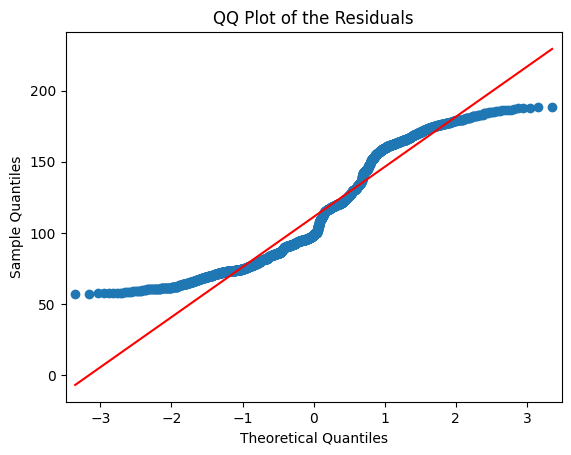

In [ ]:
fig = plt.figure(figsize=(12, 8))
sm.qqplot(ecm_model.resid, line='s')
plt.title('QQ Plot of the Residuals')
plt.show()